In [38]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_at_node_attr, add_mut_accumulation_attr
from utils import get_parent, prune_tree
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.gridspec as gridspec
from collections import Counter
import requests
import math

## Figure 5: Clades with the 3-amino acid deletion in Nsp6 have a higher number of S1 mutations

##### Find the difference between S1 substitutions before and after convergently-evolved mutations. The average increase in S1 substitutions after ORF1a:3675-3677del clades is higher than after other convergently-evolved mutations

#### This notebook completes the analyses for Figures 5B .

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [20]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [23]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [24]:
tree = add_syn_mut_attribute(tree)

Add the number of mutations that occur at a node as an attribute of that node, for all nodes on the tree

In [25]:
tree = add_mut_at_node_attr(tree)

Add an attribute to each node that gives the total number of mutations accumulated between the tree root and that node (including mutations on the node). 

In [35]:
tree = add_mut_accumulation_attr(tree)

For every occurrence of a convergently-evolved mutation, find the number of S1 mutations that had accumulated by the branch before the mutation.

In [108]:
def get_branches_with_muts(gene, mutation, in_s1):
    """
    Find internal branches with the convergently-evolved mutation.
    Return a dictionary with the name of this branch, the S1 and 
    RdRp accumulation before this branch, and the number of S1 (syn 
    and nonsyn) and RdRp (nonsyn) mutations on this branch
    """
    
    mut_history = {}
    
    for node in tree.find_clades(terminal=False):

        if len(node.get_terminals()) >=15:
            
            # finds branchs with the mutation
            if hasattr(node, "branch_attrs") and "mutations" in node.branch_attrs:
                if gene in node.branch_attrs["mutations"]:
                    for m in node.branch_attrs["mutations"][gene]:
                        if mutation in m:
                            # find the number of mutations on this node
                            s1_this_node = node.nonsyn_at_node['S1']
                            rdrp_this_node = node.nonsyn_at_node['RdRp']
                            s1_syn_this_node = node.syn_at_node['S1']
                            
                            # find the date this mutation occurred and the amount 
                            # of time between the root and this mutation
                            mut_date = node.node_attrs["num_date"]["value"]
                            start_date = get_parent(tree, node)[0].node_attrs["num_date"]["value"]
                            time_before_mut = mut_date - start_date

                            # find the branch before this mutation and count mutations there
                            direct_parent = get_parent(tree, node)[-2]
                            s1_before = direct_parent.node_attrs['s1_accumulation']
                            rdrp_before = direct_parent.node_attrs['rdrp_accumulation']
                            s1_syn_before = direct_parent.node_attrs['s1_syn_accumulation']
                            
                            # don't count itself as an accumulated mutation
                            if in_s1 ==True:
                                s1_this_node = s1_this_node-1


                            mut_history[node.name] = {'branch_with_mut':node.name, 
                                                      's1_muts_at_branch': s1_this_node, 
                                                      'rdrp_muts_at_branch': rdrp_this_node, 
                                                      's1_syn_muts_at_branch': s1_syn_this_node, 
                                                      's1_muts_before': s1_before, 
                                                      'rdrp_muts_before': rdrp_before,
                                                      's1_syn_before': s1_syn_before, 
                                                      'mut_date': mut_date, 
                                                      'time_before_mut': time_before_mut}
    return mut_history   

Then find the S1 mutation accumulation number at the end of every path (but truncate tree at branches with at least 5 descending tips) descending from the mutation. 

In [134]:
# list of all "terminal" branches on a tree that has been pruned to only have branches with 5 or more desending tips
pruned_terminals = prune_tree(tree, 1)

In [136]:
def num_muts_in_children(gene, mutation, in_s1):
    """
    For each convergently-evolved mutation, find S1 accumulation 
    on the end of paths descending from the mutation. Truncate the 
    tree to branches with at least 3 descending tips to avoid 
    sequencing errors. If the convergently-evolved mutation is in 
    S1, do not count itself in the mutation total.
    """
    
    # dictionary with branches the mutation occurred on and how many 
    # S1, S1 syn and RdRp mutations were present before
    mut_history = get_branches_with_muts(gene, mutation, in_s1)
    # list of branches where convergently-evolved mutation occurred
    branchs_with_mut = [x for x in mut_history.keys()]
    
    # initialize dictionary to keep track of the increase in 
    # S1, S1 syn and RdRp mutation accumulation after specified mutation
    mut_increase = {}
    
    
    # for each occurrence
    for branch_w_mut in branchs_with_mut:

        # initialize list of dictionaries to store node name of path ends, 
        # and how many S1, S1 syn and RdRp mutations are there
        path_ends = []
        
        # initialize dict to store mutation increases after specified mut
        mut_increase_after_occurrence = {'s1':[], 's1_syn':[], 'rdrp': []}
        
        for node in tree.find_clades(terminal=False):
            
            # only look at "terminals" of pruned tree
            if node.name in pruned_terminals:


                parents = get_parent(tree, node)[:-1]
                parent_names = [p.name for p in parents]
                # if branch is a descendent of the specified mutation
                if branch_w_mut in parent_names:
                    s1_after = node.node_attrs['s1_accumulation']
                    rdrp_after = node.node_attrs['rdrp_accumulation']
                    s1_syn_after = node.node_attrs['s1_syn_accumulation']
                    
                    if in_s1 == True:
                        s1_after = s1_after - 1

                    path_ends.append({'name': node.name, 
                                      's1_after': s1_after,
                                      'rdrp_after': rdrp_after,
                                      's1_syn_after': s1_syn_after, 
                                      'descending_tips': len(node.get_terminals())})
                    # find the increase in mutation count after
                    # count mutations on same branch as specified mutation as having happened before
#                     s1_before = mut_history[branch_w_mut]['s1_muts_before']+mut_history[branch_w_mut]['s1_muts_at_branch']
                    # count mutations on same branch as having happened after 
#                     s1_before = mut_history[branch_w_mut]['s1_muts_before']
                    s1_before = mut_history[branch_w_mut]['s1_muts_before']+mut_history[branch_w_mut]['s1_muts_at_branch']
                    s1_increase = s1_after-s1_before
                    mut_increase_after_occurrence['s1'].append(s1_increase)
#                     rdrp_before = mut_history[branch_w_mut]['rdrp_muts_before']
                    rdrp_before = mut_history[branch_w_mut]['rdrp_muts_before']+mut_history[branch_w_mut]['rdrp_muts_at_branch']
                    rdrp_increase = rdrp_after-rdrp_before
                    mut_increase_after_occurrence['rdrp'].append(rdrp_increase)
#                     s1_syn_before = mut_history[branch_w_mut]['s1_syn_before']
                    s1_syn_before = mut_history[branch_w_mut]['s1_syn_before']+mut_history[branch_w_mut]['s1_syn_muts_at_branch']
                    s1_syn_increase = s1_syn_after-s1_syn_before
                    mut_increase_after_occurrence['s1_syn'].append(s1_syn_increase)
                    
                    
        # add information about end mutation accumulation to mut_history dict
        mut_history[branch_w_mut]['s1_muts_after'] = path_ends
        
        # add information about mutation increase after specified mutation
        mut_increase[branch_w_mut] = mut_increase_after_occurrence



    return mut_history, mut_increase

In [118]:
def fig5b(list_of_muts, filename=None):
    """
    For each convergently-evolved mutation, plot the difference in the 
    number of S1 mutations before and after 
    """

    to_plot_diffs = []

    for m in list_of_muts:
        gene = m.split(':')[0]
        # the only S muts considered are in S1
        if gene == 'S':
            in_s1 = True
        else:
            in_s1 = False

        mutation = m.split(':')[1]
        
        if m=='ORF1a:3675-':
            m_label = 'ORF1a:3675-3677del'
        else:
            m_label = m
        
        # find info about mutation increase after each occurrence
        mut_history, mut_increase = num_muts_in_children(gene, mutation, in_s1)
        
        # make a tidy dataframe where each row is the difference in a category of muations at the end of a path
        for k,v in mut_increase.items():
            for loc, diffs in v.items():
                for diff in diffs:
                    to_plot_diffs.append({'gene': gene, 'mutation': m_label, 
                                          'accumulation_location': loc, 'difference': diff})
            
    to_plot_diffs_df = pd.DataFrame(to_plot_diffs)
    
    # initialize figure
    fig, ax = plt.subplots(figsize=(8,8))
    sns.set_style('white')

    cmap = {'s1':"#4770eb", 'rdrp': "#ff8c3a", 's1_syn':"#a7c9f1"}
    
    # order mutations for plotting by which has the largest increase in S1 accumulation
    mutation_ranks = to_plot_diffs_df[to_plot_diffs_df['accumulation_location']=='s1'
                                     ].groupby('mutation')['difference'].mean().rank(ascending=False).to_dict()
    ranked_mutations = [k for k, v in sorted(mutation_ranks.items(), key=lambda item: item[1])]
    
    # plot the difference in S1, S1 syn and RdRp mutations after the convergently-evolved mutation
    # group data by the convergently-evolved mutation being considered
    # color points by accumulated mutation type
    ax = sns.pointplot(x='mutation', y='difference', data=to_plot_diffs_df, 
                       hue='accumulation_location',palette=cmap, order= ranked_mutations, 
                       hue_order=['s1', 's1_syn', 'rdrp'],
                       join=False, dodge=True, ax=ax, scale=1.5, errwidth=1.5)

    ax.set_ylabel('Mean increase in mutations after specified event', fontsize = 14)
    ax.set_xlabel('Event', fontsize = 14)


    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, ['S1', 'S1 syn', 'RdRp'], loc='upper center', bbox_to_anchor=(0.85, 0.95), 
                     title = 'Mutations')
    

    plt.xticks(rotation=40, va='top', ha='right')

    sns.despine(left=False, bottom=False)
    
    plt.figtext(0.03, 0.88, 'B', fontsize=24, fontweight='bold')
    
    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')


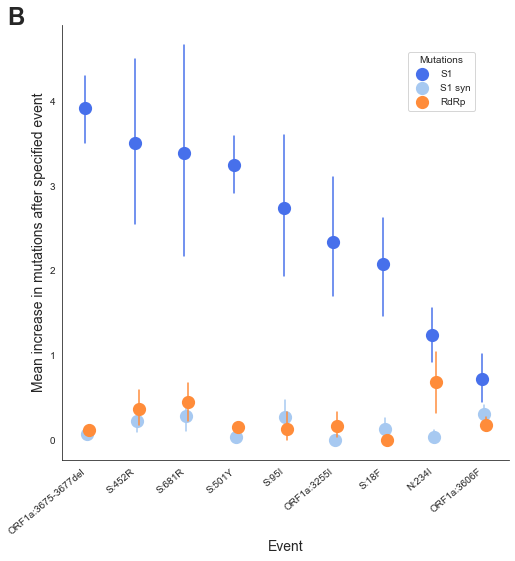

In [130]:
# 5, at branch and after
fig5b(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F',
       'S:452R', 'S:681R', 'N:234I'], filename='plots/fig5b_20210515.png')

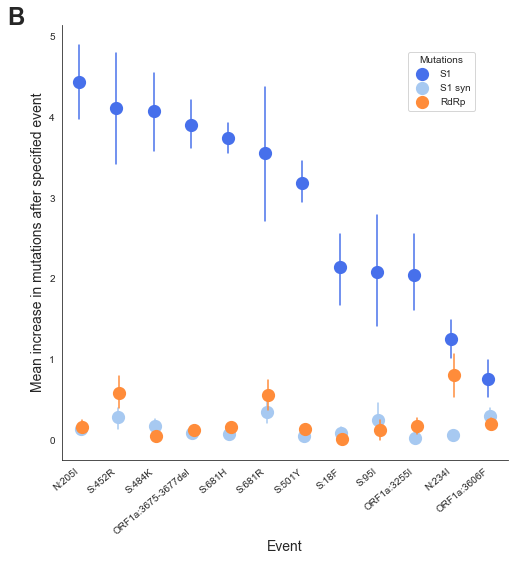

In [133]:
# 3, at branch and after
fig5b(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F', 
       'S:484K', 'S:681H',
       'S:452R', 'S:681R', 'N:234I', 'N:205I'])

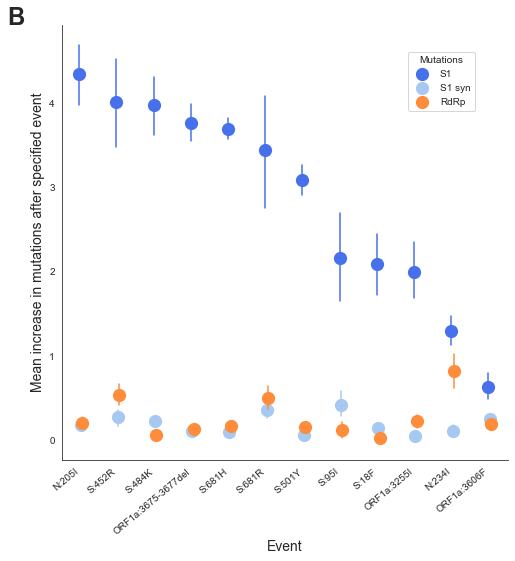

In [135]:
# 1, at branch and after
fig5b(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F', 
       'S:484K', 'S:681H',
       'S:452R', 'S:681R', 'N:234I', 'N:205I'])

In [ ]:
# 3, after
fig5b(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F', 
       'S:484K', 'S:681H',
       'S:452R', 'S:681R', 'N:234I', 'N:205I'])

In [ ]:
# 1, after
fig5b(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F', 
       'S:484K', 'S:681H',
       'S:452R', 'S:681R', 'N:234I', 'N:205I'])

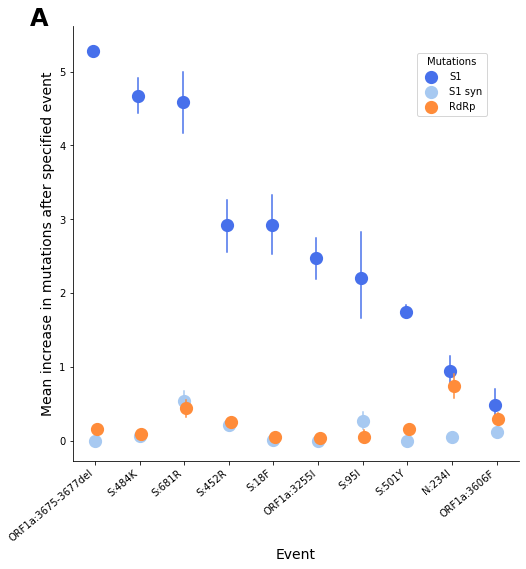

In [32]:
fig4b(['ORF1a:3675-', 'ORF1a:3606F', 'ORF1a:3255I','S:501Y', 'S:95I', 'S:18F',
       'S:484K', 'S:452R', 'S:681R', 'N:234I'], filename='plots/fig4a_20210519.png')